In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV,TunedThresholdClassifierCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix,  ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import shap

In [114]:
employee = pd.read_sql("SELECT * FROM employee",con="mssql+pyodbc://DESKTOP-F3FJIDA/Ammar?driver=ODBC+Driver+17+for+SQL+Server")

In [ ]:
employee.head() 

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [ ]:
X = employee.drop("LeaveOrNot",axis=1)
y = employee["LeaveOrNot"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1934, 8), (1934,), (830, 8), (830,))

In [ ]:
y_test.value_counts(normalize=True) # Provjeravamo balans

LeaveOrNot
0    0.646988
1    0.353012
Name: proportion, dtype: float64

In [ ]:
# ENKODIRANJE KATEGORIČKIH VARIJABLI

# Moramo prvo enkodirati podatke iz kolona X_train
hot_cols = ['City', 'Gender']

onehot = OneHotEncoder(sparse_output=False).fit(X_train[hot_cols])

one_hot_encoded = onehot.transform(X_train[hot_cols])
one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=onehot.get_feature_names_out())
one_hot_encoded.reset_index(inplace=True,drop=True)

# Enkodiranje ordinalne kolone education, EverBenched i PaymentTier
ordinal = OrdinalEncoder(categories=[["PHD","Bachelors","Masters"],["No","Yes"],["3","1","2"]]).fit(X_train[["Education","EverBenched","PaymentTier"]].astype("str")).set_output(transform="pandas")
edu_encoded = ordinal.transform(X_train[["Education","EverBenched","PaymentTier"]].astype("str"))
edu_encoded.reset_index(inplace=True,drop=True)



In [121]:
# ENKODIRAN DF

X_train_encoded = pd.concat([one_hot_encoded,edu_encoded,X_train[["JoiningYear", "Age", "ExperienceInCurrentDomain"]].reset_index(drop=True)],axis=1)


X_train_encoded

,City_Bangalore,City_New Delhi,City_Pune,Gender_Female,Gender_Male,Education,EverBenched,PaymentTier,JoiningYear,Age,ExperienceInCurrentDomain
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2015,23,1
1,0.0,1.0,0.0,0.0,1.0,2.0,0.0,2.0,2017,30,1
2,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,2018,38,2
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2012,26,4
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2018,33,4
...,...,...,...,...,...,...,...,...,...,...,...
1929,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,2015,26,4
1930,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,2012,31,4
1931,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2016,34,1
1932,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,2013,23,1


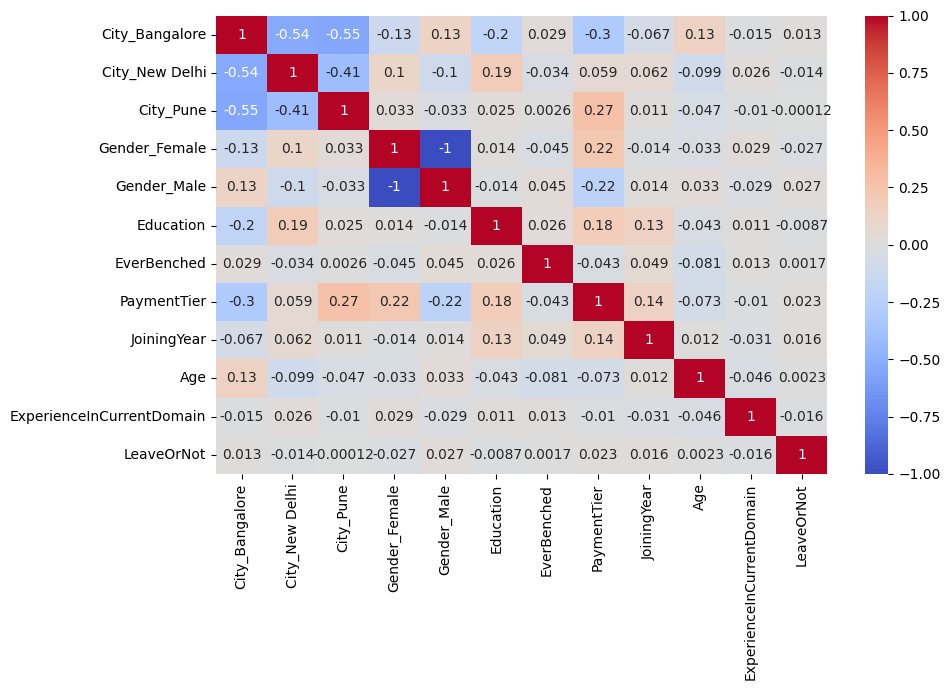

In [ ]:
# Korelacija nakon enkodiranja


plt.figure(figsize=(10,7))
sns.heatmap(pd.concat([X_train_encoded,y_train],axis=1).corr(),annot=True,cmap="coolwarm")
plt.tight_layout()
plt.show()

In [123]:
#SKALIRANJE

minmax = MinMaxScaler().set_output(transform="pandas").fit(X_train_encoded)

X_train_scaled = minmax.transform(X_train_encoded)

In [ ]:
# Optimizacija hyperparametara
# Meni je kuci trebalo oko 5:30 min da zavrsi

pipe = Pipeline([
    ("classifier",  [RandomForestClassifier()])
])

param_grid = [
    {
        "classifier" : [SVC()],
        "classifier__C" : [0.3, 0.5, 1],
        "classifier__kernel" : ["linear", "rbf", "sigmoid"],
        "classifier__gamma" : ['scale', 'auto'],
        "classifier__degree" : [2,3,4]
    },
    {
        "classifier" : [RandomForestClassifier()],
        "classifier__n_estimators" : [50,100,200,500],
        "classifier__criterion" : ["gini", "entropy", "log_loss"],
        "classifier__max_depth" : [5,8,10,None],
        "classifier__max_features" : ['sqrt', 'log2',None],
        "classifier__min_samples_split" : [2,4,6],
        "classifier__min_samples_leaf" : [1,3,5]
    },
    {
        "classifier" : [KNeighborsClassifier()],
        "classifier__n_neighbors" : [3,5,8],
        "classifier__weights" : ["uniform", "distance"],
        "classifier__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    {
        "classifier" : [GradientBoostingClassifier()],
        "classifier__loss" : ['log_loss', 'deviance', 'exponential'],
        "classifier__learning_rate" : [1, 0.4, 0.7],
        "classifier__n_estimators" : [50,100,200],
        "classifier__max_depth" : [3,5,8]
    },
    {
        "classifier" : [AdaBoostClassifier()],
        "classifier__n_estimators" : [50,100,150],
        "classifier__learning_rate" : [0.5, 1, 1.5],
        "classifier__algorithm" : ['SAMME', 'SAMME.R']
    },
    {
        "classifier" : [LogisticRegression()],
        "classifier__C" : [0.5, 1.0, 1.5],
        "classifier__penalty" : ['l1', 'l2', 'elasticnet'],
        "classifier__max_iter" : [50,100,150],
        "classifier__fit_intercept" : [True, False]
    }]


grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring="f1", verbose=2)

grid.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 1527 candidates, totalling 7635 fits


c:\Users\aaaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
360 fits failed out of a total of 7635.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
39 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aaaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aaaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aaaa\AppData

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        [RandomForestClassifier()])]),
             n_jobs=-1,
             param_grid=[{'classifier': [SVC()], 'classifier__C': [0.3, 0.5, 1],
                          'classifier__degree': [2, 3, 4],
                          'classifier__gamma': ['scale', 'auto'],
                          'classifier__kernel': ['linear', 'rbf', 'sigmoid']},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__criterion': ['gini', 'e...
                         {'classifier': [AdaBoostClassifier()],
                          'classifier__algorithm': ['SAMME', 'SAMME.R'],
                          'classifier__learning_rate': [0.5, 1, 1.5],
                          'classifier__n_estimators': [50, 100, 150]},
                         {'classifier': [LogisticRegression()],
                          'classifier__C': [0.5, 1.0, 1.5],
                          'classifier__fit_intercept': [True, False],
                          'classifier__max_iter': [50, 100, 150],
                          'classifier__penalty': ['l1', 'l2', 'elasticnet']}],
             scoring='f1', verbose=2)

In [46]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'classifier': RandomForestClassifier(), 'classifier__criterion': 'gini', 'classifier__max_depth': 8, 'classifier__max_features': None, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
0.7271439531020178
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        min_samples_leaf=5,
                                        n_estimators=200))])


In [124]:
# Kreiramo model
model = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=8, max_features=None, min_samples_leaf=5, min_samples_split=2)
model.fit(X_train_scaled,y_train)

RandomForestClassifier(max_depth=8, max_features=None, min_samples_leaf=5,
                       n_estimators=200)

In [125]:
# ENKODIRANJE X_test df-a

one_hot_encoded_test = onehot.transform(X_test[hot_cols])
one_hot_encoded_test = pd.DataFrame(one_hot_encoded_test, columns=onehot.get_feature_names_out())
one_hot_encoded_test.reset_index(inplace=True, drop=True)

edu_encoded_test = ordinal.transform(X_test[["Education","EverBenched","PaymentTier"]].astype("str"))
edu_encoded_test.reset_index(inplace=True, drop=True)

X_test_encoded = pd.concat([one_hot_encoded_test,edu_encoded_test,X_test[["JoiningYear", "Age", "ExperienceInCurrentDomain"]].reset_index(drop=True)],axis=1)

X_test_encoded

,City_Bangalore,City_New Delhi,City_Pune,Gender_Female,Gender_Male,Education,EverBenched,PaymentTier,JoiningYear,Age,ExperienceInCurrentDomain
0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,2012,29,1
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2015,28,0
2,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,2016,32,1
3,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,2015,25,3
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2015,41,0
...,...,...,...,...,...,...,...,...,...,...,...
825,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,2017,26,4
826,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,2016,24,2
827,0.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,2017,30,2
828,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2017,27,5


In [126]:
# Skaliranje X_test

X_test_scaled = minmax.transform(X_test_encoded)
X_test_scaled

,City_Bangalore,City_New Delhi,City_Pune,Gender_Female,Gender_Male,Education,EverBenched,PaymentTier,JoiningYear,Age,ExperienceInCurrentDomain
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.5,0.000000,0.368421,0.142857
1,1.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.500000,0.315789,0.000000
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.666667,0.526316,0.142857
3,1.0,0.0,0.0,1.0,0.0,0.5,1.0,0.5,0.500000,0.157895,0.428571
4,1.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.500000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
825,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.833333,0.210526,0.571429
826,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.666667,0.105263,0.285714
827,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.833333,0.421053,0.285714
828,1.0,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.833333,0.263158,0.714286


In [127]:
#Pravimo predikciju na osnovu X_test
y_pred = model.predict(X_test_scaled)


In [128]:
# Metrike 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       537
           1       0.82      0.68      0.74       293

    accuracy                           0.83       830
   macro avg       0.83      0.80      0.81       830
weighted avg       0.83      0.83      0.83       830



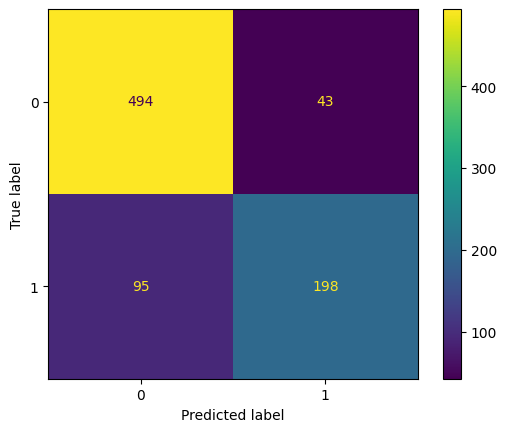

In [129]:
print(ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot())

In [145]:
print(roc_auc_score(y_test,y_pred))

0.7978467150965101


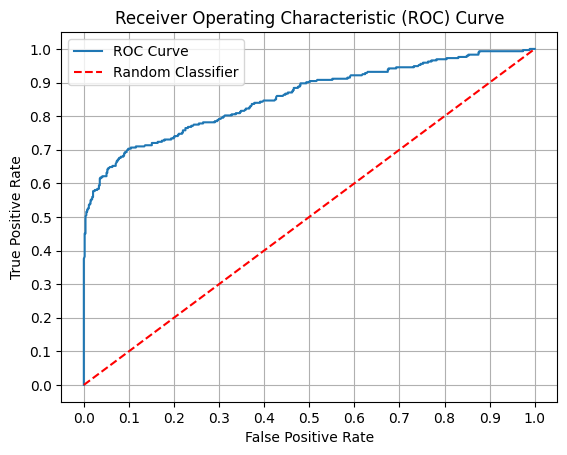

In [ ]:
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba)

plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.xticks([0,0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel('True Positive Rate')
plt.yticks([0,0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Shap da bi bolje razumjeli model

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train_scaled)


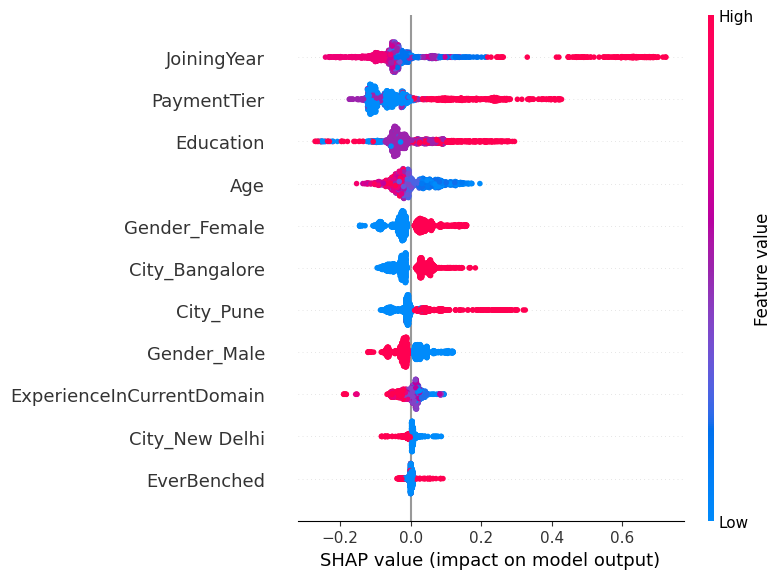

In [132]:
shap.summary_plot(shap_values[:,:,1], X_train_scaled)

In [ ]:
# Tuned

classifier_tuned = TunedThresholdClassifierCV(model, scoring="f1").fit(X_train_scaled, y_train)

print(f"Cut-off point found at {classifier_tuned.best_threshold_:.3f}")

print(classification_report(y_test, classifier_tuned.predict(X_test_scaled)))

Cut-off point found at 0.427
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       537
           1       0.79      0.71      0.74       293

    accuracy                           0.83       830
   macro avg       0.82      0.80      0.81       830
weighted avg       0.83      0.83      0.83       830

